# Initial thoughts on multi-solution problems

In [1]:
import numpy
import csv
import pandas
import os
from itertools import combinations, permutations
from collections import OrderedDict
from scipy.spatial.distance import cdist
from scipy.special import jv

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import colors as mcolors
%matplotlib inline

sigopt_colors = [
    '#1f407d',
    '#2291cf',
    '#f89b20',
    '#fbbf15',
]
cmap_sigopt = mcolors.LinearSegmentedColormap.from_list('brand_colors', sigopt_colors, N=200)

In the field below we define the SigOpt connection.  It will check your environment for an API token and, if it cannot find it, you may define your token here instead.  You can also use your [development token](https://sigopt.com/docs/overview/authentication) if you are testing your workflow.

There is also a requirement that you affirm you want to create SigOpt experiments -- we know that some people execute notebooks quickly and we do not want customers creating experiments unnecessarily.

In [35]:
from sigopt.interface import Connection

if 'SIGOPT_API_TOKEN' in os.environ:
    SIGOPT_API_TOKEN = os.environ['SIGOPT_API_TOKEN']
else:
    SIGOPT_API_TOKEN = None
    assert SIGOPT_API_TOKEN is not None
SIGOPT_API_TOKEN = 'client_token'
conn = Connection(client_token=SIGOPT_API_TOKEN)
conn.set_api_url(api_url='http://0.0.0.0:5000')

I_AM_OKAY_CREATING_EXPERIMENTS = True
assert I_AM_OKAY_CREATING_EXPERIMENTS

We can now create some simple test functions on which we will study different strategies.

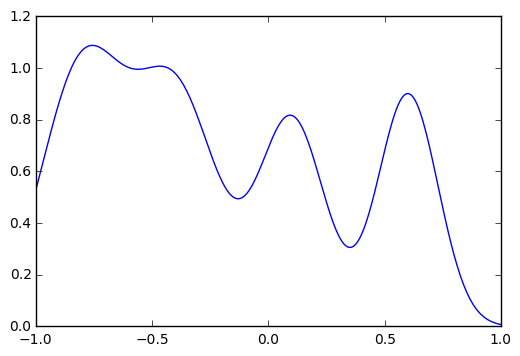

In [3]:
def test_function_1d(x1):
    return (
        numpy.exp(-16 * (x1 + .8) ** 2) +
        .9 * numpy.exp(-16 * (x1 + .4) ** 2) +
        .8 * numpy.exp(-25 * (x1 - .1) ** 2) +
        .9 * numpy.exp(-30 * (x1 - .6) ** 2)
    )

parameters_1d = [{'name': 'x1', 'bounds': {'min': -1.0, 'max': 1.0}, 'type': 'double'}]

xplt = numpy.linspace(parameters_1d[0]['bounds']['min'], parameters_1d[0]['bounds']['max'], 300)
yplt = numpy.array([test_function_1d(xx) for xx in xplt])
plt.plot(xplt, yplt);

/Users/mccourt/Envs/moe_venv/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/Users/mccourt/Envs/moe_venv/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


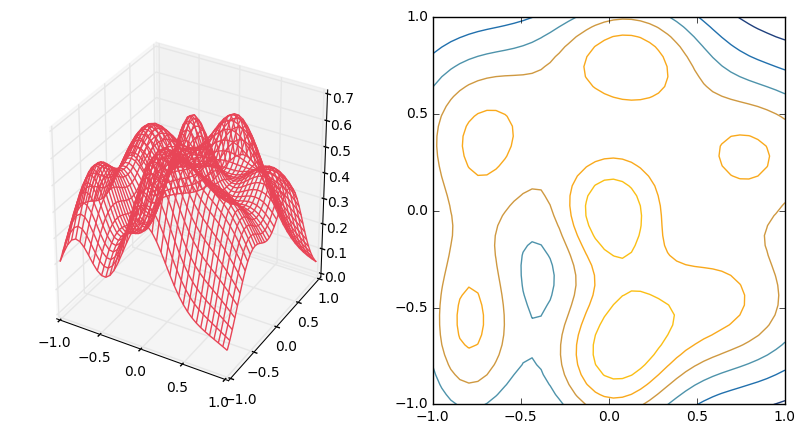

In [4]:
def test_function_2d(x1, x2):
    return (
        .5 * numpy.exp(-10 * ((x1 + .8) ** 2 + .3 * (x2 + .6) ** 2)) +
        .5 * numpy.exp(-9 * (.4 * (x1 + .7) ** 2 + .4 * (x2 - .4) ** 2)) +
        .5 * numpy.exp(-11 * (.2 * (x1 - .6) ** 2 + .5 * (x2 + .5) ** 2)) +
        .5 * numpy.exp(-11 * (.6 * (x1) ** 2 + .5 * (x2 + .8) ** 2)) +
        .5 * numpy.exp(-12 * (.4 * (x1 - .1) ** 2 + .7 * (x2 - .8) ** 2)) +
        .5 * numpy.exp(-13 * (.8 * (x1) ** 2 + .7 * (x2) ** 2)) +
        .5 * numpy.exp(-8 * (.3 * (x1 - .8) ** 2 + .6 * (x2 - .3) ** 2))
    )

parameters_2d = [
    {'name': 'x1', 'bounds': {'min': -1.0, 'max': 1.0}, 'type': 'double'},
    {'name': 'x2', 'bounds': {'min': -1.0, 'max': 1.0}, 'type': 'double'},
]

xplt1 = numpy.linspace(parameters_2d[0]['bounds']['min'], parameters_2d[0]['bounds']['max'], 40)
xplt2 = numpy.linspace(parameters_2d[1]['bounds']['min'], parameters_2d[1]['bounds']['max'], 40)
X1_2D, X2_2D = numpy.meshgrid(xplt1, xplt2)
Y_2D = test_function_2d(X1_2D, X2_2D)
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(121, projection='3d')
ax.plot_wireframe(X1_2D, X2_2D, Y_2D, color='#E84557')
ax = fig.add_subplot(122)
ax.contour(X1_2D, X2_2D, Y_2D, cmap=cmap_sigopt);

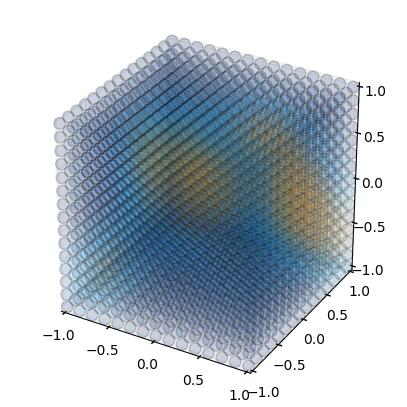

In [5]:
def test_function_3d(x1, x2, x3):  # Assume function accepts values SigOpt (dict) style
    return (
        .5 * numpy.exp(-10 * ((x1 + .8) ** 2 + .3 * (x2 + .6) ** 2 + .7 * (x3 + .7) ** 2)) +
        .5 * numpy.exp(-9 * (.4 * (x1 + .7) ** 2 + .4 * (x2 - .4) ** 2 + .4 * (x3 - .1) ** 2)) +
        .5 * numpy.exp(-11 * (.2 * (x1 - .6) ** 2 + .5 * (x2 + .5) ** 2 + .6 * (x3 + .2) ** 2)) +
        .5 * numpy.exp(-11 * (.6 * (x1) ** 2 + .5 * (x2 + .8) ** 2 + .3 * (x3 - .8) ** 2)) +
        .5 * numpy.exp(-12 * (.4 * (x1 - .1) ** 2 + .7 * (x2 - .8) ** 2 + .8 * (x3 - .4) ** 2)) +
        .5 * numpy.exp(-13 * (.8 * (x1) ** 2 + .7 * (x2) ** 2 + .5 * (x3) ** 2)) +
        .5 * numpy.exp(-8 * (.3 * (x1 - .8) ** 2 + .6 * (x2 - .9) ** 2 + .3 * (x3 + .6) ** 2)) +
        .5 * numpy.exp(-8 * (.5 * (x1 - .3) ** 2 + .5 * (x2 + .2) ** 2 + .5 * (x3 - .4) ** 2)) +
        .5 * numpy.exp(-8 * (.5 * (x1 + .4) ** 2 + .4 * (x2 - .3) ** 2 + .7 * (x3 + .3) ** 2)) +
        .5 * numpy.exp(-8 * (.8 * (x1 + .2) ** 2 + .5 * (x2 + .6) ** 2 + .7 * (x3 - .9) ** 2)) +
        .5 * numpy.exp(-8 * (.9 * (x1 - .5) ** 2 + .6 * (x2 - .7) ** 2 + .4 * (x3 + .1) ** 2))
    )

parameters_3d = [
    {'name': 'x1', 'bounds': {'min': -1.0, 'max': 1.0}, 'type': 'double'},
    {'name': 'x2', 'bounds': {'min': -1.0, 'max': 1.0}, 'type': 'double'},
    {'name': 'x3', 'bounds': {'min': -1.0, 'max': 1.0}, 'type': 'double'},
]

xplt1 = numpy.linspace(parameters_3d[0]['bounds']['min'], parameters_3d[0]['bounds']['max'], 15)
xplt2 = numpy.linspace(parameters_3d[1]['bounds']['min'], parameters_3d[1]['bounds']['max'], 15)
xplt3 = numpy.linspace(parameters_3d[2]['bounds']['min'], parameters_3d[2]['bounds']['max'], 15)
X1_3D, X2_3D, X3_3D = numpy.meshgrid(xplt1, xplt2, xplt3)
Y_3D = test_function_3d(X1_3D, X2_3D, X3_3D)
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X1_3D.flat, X2_3D.flat, X3_3D.flat, c=Y_3D.flat, s=70, marker='o', alpha=.2, cmap=cmap_sigopt, vmin=numpy.min(Y_3D), vmax=numpy.max(Y_3D))
ax.set_xlim((-1, 1))
ax.set_ylim((-1, 1))
ax.set_zlim((-1, 1));

We define below functions based on a definition of distance between points and a desire to avoid solutions being too close to each other.  Thus, at least qualitatively, we want high function values and points that are far apart.  We also could phrase this as a penalty function for points that are too close together, and then consider low penalty solutions.

In [6]:
def pairwise_distance_function(o1, o2):
    assert o1.keys() == o2.keys()
    return numpy.sqrt(sum([(o1[key] - o2[key]) ** 2 for key in o1]))

def list_distance_function(observation_dict_list):
    cumulative_dist = 0
    for param_list_a, param_list_b in combinations(observation_dict_list, 2):
        assert param_list_a.keys() == param_list_b.keys()
        dist_sq = sum([(param_list_a[param] - param_list_b[param]) ** 2 for param in param_list_a])
        if dist_sq == 0:
            raise AssertionError('Identical parameters:\n{0}\n{1}'.format(param_list_a, param_list_b))
        cumulative_dist += 1 / dist_sq
    return numpy.sqrt(1 / cumulative_dist)

# Attempt an iterative solution strategy

In this setting, solutions are found iteratively: first a solution is found and then future observations near it will be treated as failures.  This will create regions of failures where SigOpt then knows not to search.  For each desired "solution", a new SigOpt experiment is created using failures as defined by any previous solutions.

The number of optima does not need to be specified at the start of the process -- experiments could continue to be created for as long as desired (or until the entire region is failures).  Given that, here we are assuming that we have specified it _a priori_.

The penalty radius defines how far apart the solutions must be.  After the first solution, a ball around it with this penalty radius will prevent future solutions from existing there.  This value is **very** important; if it is chosen too small or too large it may push the solutions into an undesirable form.  Of course, knowing the appropriate value may be difficult.

The number of trials per optimum can be the same as what is normally used in an experiment, i.e., 10-20x the number of parameters

This function is designed to allow us to reuse observations from previous experiments, which is more efficient than just throwing them away.

A "+" is appended to the experiment name for each optimum that has already been found (just for simplicity in viewing.

In [7]:
def move_observations_to_new_experiment(conn, old_experiment_id, found_optima, penalty_radius):
    if not found_optima:
        return conn.experiments(old_experiment_id).fetch()
    
    old_experiment = conn.experiments(old_experiment_id).fetch()
    assert I_AM_OKAY_CREATING_EXPERIMENTS
    new_experiment = conn.experiments().create(
        name='{0}+'.format(old_experiment.name),
        parameters=old_experiment.parameters,
    )
    for obs in conn.experiments(old_experiment_id).observations().fetch().iterate_pages():
        value = obs.value
        failed = obs.failed
        for previous_optimum in found_optima:
            if not failed and distance_function(obs.assignments, previous_optimum.assignments) < penalty_radius:
                value = None
                failed = True
        conn.experiments(new_experiment.id).observations().create(
            assignments=obs.assignments,
            value=value,
            failed=failed,
            metadata=obs.metadata,
        )
    
    return conn.experiments(new_experiment.id).fetch()

In [8]:
test_function = test_function_1d
distance_function = pairwise_distance_function
experiment_name = 'Iterative multisolution test 1D'
parameters = parameters_1d

num_optima = 3
penalty_radius = .15
num_trials_per_optimum = 10

In [9]:
assert I_AM_OKAY_CREATING_EXPERIMENTS
experiment = conn.experiments().create(
    name=experiment_name,
    parameters=parameters,
)

This is the actual iterative solution strategy.  The plotting content will vary based on the dimension of the problem.

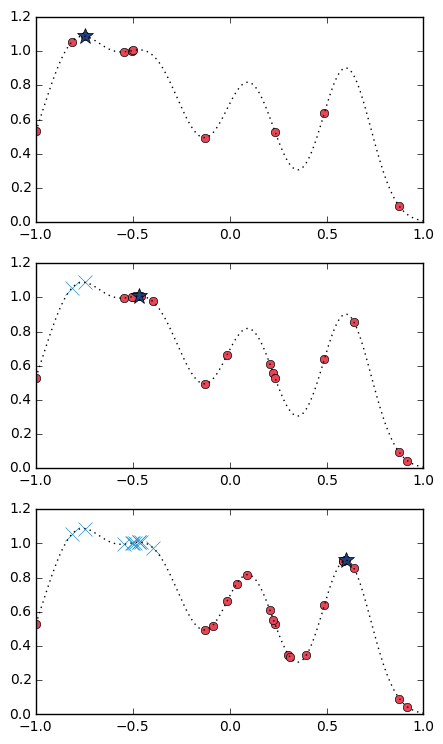

In [10]:
fig, axes = plt.subplots(num_optima, 1, figsize=(5, 3 * num_optima))

found_optima = []
for which_optimum, ax in enumerate(axes):
    experiment = move_observations_to_new_experiment(conn, experiment.id, found_optima, penalty_radius)
    
    for trial in range(num_trials_per_optimum):
        suggestion = conn.experiments(experiment.id).suggestions().create()
        true_value = test_function(**suggestion.assignments)
        value = true_value
        failed = False
        for previous_optimum in found_optima:
            if distance_function(suggestion.assignments, previous_optimum.assignments) < penalty_radius:
                value = None
                failed = True
        conn.experiments(experiment.id).observations().create(
            suggestion=suggestion.id,
            value=value,
            failed=failed,
            metadata={'found_during': which_optimum, 'true_value': true_value},
        )
    found_optima.append(conn.experiments(experiment.id).fetch().progress.best_observation)
    
    # This plotting content can be commented out
    x = []
    y = []
    x_fail = []
    y_fail = []
    for obs in conn.experiments(experiment.id).observations().fetch().iterate_pages():
        if obs.failed:
            x_fail.append(obs.assignments['x1'])
            y_fail.append(obs.metadata['true_value'])
        else:
            x.append(obs.assignments['x1'])
            y.append(obs.value)
    ax.plot(x, y, 'o', color='#E84557')
    ax.plot(x_fail, y_fail, 'x', markersize=10, color='#2291CF')
    ax.plot(found_optima[-1].assignments['x1'], found_optima[-1].value, '*', color='#1F407D', markersize=12)
    ax.plot(xplt, yplt, ':k')

In [11]:
test_function = test_function_2d
distance_function = pairwise_distance_function
experiment_name = 'Iterative multisolution test 2D'
parameters = parameters_2d

num_optima = 4
penalty_radius = .25
num_trials_per_optimum = 20

In [12]:
assert I_AM_OKAY_CREATING_EXPERIMENTS
experiment = conn.experiments().create(
    name=experiment_name,
    parameters=parameters,
)

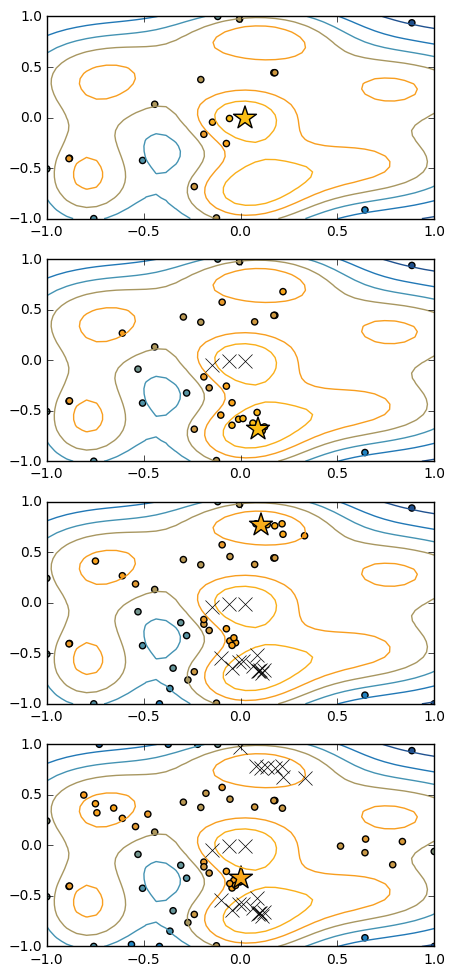

In [13]:
fig, axes = plt.subplots(num_optima, 1, figsize=(5, 3 * num_optima))

found_optima = []
for which_optimum, ax in enumerate(axes):
    experiment = move_observations_to_new_experiment(conn, experiment.id, found_optima, penalty_radius)
    
    for trial in range(num_trials_per_optimum):
        suggestion = conn.experiments(experiment.id).suggestions().create()
        true_value = test_function(**suggestion.assignments)
        value = true_value
        failed = False
        for previous_optimum in found_optima:
            if distance_function(suggestion.assignments, previous_optimum.assignments) < penalty_radius:
                value = None
                failed = True
        conn.experiments(experiment.id).observations().create(
            suggestion=suggestion.id,
            value=value,
            failed=failed,
            metadata={'found_during': which_optimum, 'true_value': true_value},
        )
    found_optima.append(conn.experiments(experiment.id).fetch().progress.best_observation)
    
    x1 = []
    x2 = []
    y = []
    x1_bad = []
    x2_bad = []
    y_bad = []
    for obs in conn.experiments(experiment.id).observations().fetch().iterate_pages():
        if obs.failed:
            x1_bad.append(obs.assignments['x1'])
            x2_bad.append(obs.assignments['x2'])
            y_bad.append(numpy.min(Y_2D))
        else:
            x1.append(obs.assignments['x1'])
            x2.append(obs.assignments['x2'])
            y.append(obs.value)
    ax.contour(X1_2D, X2_2D, Y_2D, cmap=cmap_sigopt, vmin=numpy.min(Y_2D), vmax=numpy.max(Y_2D))
    ax.scatter(x1, x2, c=y, cmap=cmap_sigopt, vmin=numpy.min(Y_2D), vmax=numpy.max(Y_2D))
    ax.plot(x1_bad, x2_bad, 'x', markersize=10, color='k')
    ax.scatter([found_optima[-1].assignments['x1']], [found_optima[-1].assignments['x2']], c=[found_optima[-1].value], s=[300], marker='*', cmap=cmap_sigopt, vmin=numpy.min(Y_2D), vmax=numpy.max(Y_2D))
    ax.set_xlim((-1, 1))
    ax.set_ylim((-1, 1))

In [14]:
test_function = test_function_3d
distance_function = pairwise_distance_function
experiment_name = 'Iterative multisolution test 3D'
parameters = parameters_3d

num_optima = 4
penalty_radius = .35
num_trials_per_optimum = 30

In [15]:
assert I_AM_OKAY_CREATING_EXPERIMENTS
experiment = conn.experiments().create(
    name=experiment_name,
    parameters=parameters,
)

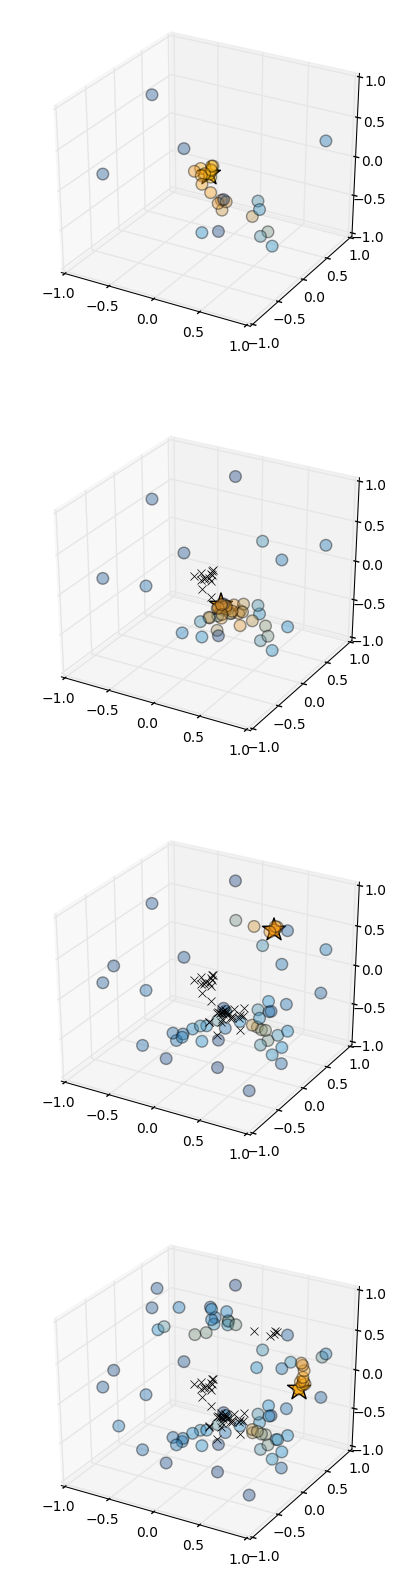

In [16]:
fig, axes = plt.subplots(num_optima, 1, figsize=(5, 5 * num_optima), subplot_kw={'projection': '3d'})

found_optima = []
for which_optimum, ax in enumerate(axes):
    experiment = move_observations_to_new_experiment(conn, experiment.id, found_optima, penalty_radius)
    
    for trial in range(num_trials_per_optimum):
        suggestion = conn.experiments(experiment.id).suggestions().create()
        true_value = test_function(**suggestion.assignments)
        value = true_value
        failed = False
        for previous_optimum in found_optima:
            if distance_function(suggestion.assignments, previous_optimum.assignments) < penalty_radius:
                value = None
                failed = True
        conn.experiments(experiment.id).observations().create(
            suggestion=suggestion.id,
            value=value,
            failed=failed,
            metadata={'found_during': which_optimum, 'true_value': true_value},
        )
    found_optima.append(conn.experiments(experiment.id).fetch().progress.best_observation)
    
    x1 = []
    x2 = []
    x3 = []
    x1_bad = []
    x2_bad = []
    x3_bad = []
    y = []
    for obs in conn.experiments(experiment.id).observations().fetch().iterate_pages():
        if obs.failed:
            x1_bad.append(obs.assignments['x1'])
            x2_bad.append(obs.assignments['x2'])
            x3_bad.append(obs.assignments['x3'])
        else:
            x1.append(obs.assignments['x1'])
            x2.append(obs.assignments['x2'])
            x3.append(obs.assignments['x3'])
            y.append(obs.value)
    ax.scatter(x1, x2, x3, c=y, s=70, marker='o', alpha=.4, cmap=cmap_sigopt, vmin=numpy.min(Y_3D), vmax=numpy.max(Y_3D))
    ax.plot(x1_bad, x2_bad, x3_bad, 'xk')
    ax.scatter([found_optima[-1].assignments['x1']], [found_optima[-1].assignments['x2']], [found_optima[-1].assignments['x3']], c=[found_optima[-1].value], s=[300], marker='*', cmap=cmap_sigopt, vmin=numpy.min(Y_3D), vmax=numpy.max(Y_3D))
    ax.set_xlim((-1, 1))
    ax.set_ylim((-1, 1))
    ax.set_zlim((-1, 1))

# Attempt a simultaneous solution strategy

In this situation we try to simultaneously create all of the best suggestions simultaneously, rather than with sequential experiments.  This is actually solving a different problem, thus the same solutions will not appear in both circumstances.  Furthermore, this also requires a sense of distance between all the points (which is done in a sort of electrostatic repulsion/harmonic mean strategy here but could be anything).

The benefit to this strategy is that points which are close to the global optimum are still viable, so long as they are relatively much better to the alternatives.  This could be relevant in a situation with only one good optimum and all other lousy values in a domain.  This could be bad in a situation where the solutions are desired to be _at least_ some distance apart.

This solves a problem which is in a **much larger** domain.  Thus, the number of points that are required to find this solution increases significantly.  As an estimate, for a 3 dimensional problem with a desire for 4 multi-solutions, it would be entirely possible to need more than 250 suggestions to get an answer.

There is a symmetry in the way solutions are presented in this formation: there is no inherent ordering between points, which means that the first and second solutions could be in reverse order without any difference.  Because of SigOpt's current interface, there is no way to manage this (we are working on internal strategies).  To account for this, we enforce a lexicographic ordering in points, and any suggestions that come from SigOpt which are out of order (many, since in higher dimensions the space of acceptable points is really small) the points get reordered and returned in the proper order to SigOpt.  This allows SigOpt to learn the acceptable region and also learn about where the unacceptable region is.

In [17]:
def create_duplicate_parameters(parameters, num_optima):
    for p in parameters:
        for k in range(num_optima):
            g = p.copy()
            g.update({'name': '{0}--{1}'.format(p['name'], k + 1)})
            yield g

def identify_individual_dicts(parameters, suggestion):
    base_params = OrderedDict()  # To maintain a consistent ordering
    index_list = []
    for param in parameters:
        name, index = param['name'].split('--')
        if name not in base_params:
            base_params[name] = OrderedDict()  # Again, for the consistent ordering
        base_params[name][int(index)] = param['name']
        if int(index) not in index_list:
            index_list.append(int(index))
        
    eval_dict_list = []
    for this_index in index_list:
        eval_dict = OrderedDict()
        for base_param, associated_params in sorted(base_params.items(), key=lambda x: x[0]):
            eval_dict[base_param] = suggestion.assignments[associated_params[this_index]]
        eval_dict_list.append(eval_dict)
    return eval_dict_list

def check_correct_order(eval_dict_list):  # Also returns false for any ties
    assert len(eval_dict_list) >= 2  # Must have at least 2 solutions to the MULTI-optimum problem
    for index in range(len(eval_dict_list) - 1):
        dict_a = eval_dict_list[index]
        dict_b = eval_dict_list[index + 1]
        assert dict_a.keys() == dict_b.keys()  # Not sure how we get here if this isn't true
        if dict_a.values() == dict_b.values():  # Cannot have two suggestions that are the same
            return False
        for param in dict_a.keys():  # Since they are not all equal, confirm that dict_a > dict_b
            if dict_a[param] > dict_b[param]:
                break  # These two suggestions are in the correct order
            elif dict_a[param] < dict_b[param]:
                return False
    return True

def pivot_dict_to_correct_ordering(eval_dict_list):
    for permuted_eval_dict_list in permutations(eval_dict_list):
        if check_correct_order(permuted_eval_dict_list):
            return permuted_eval_dict_list
        
def reconstruct_assignments_from_eval_dict_list(eval_dict_list):
    assignments = {}
    for index, ed in enumerate(eval_dict_list):
        for var_name, val in ed.items():
            assignments[var_name + '--' + str(index + 1)] = val
    return assignments
        
def create_success_and_failure_observations(suggestion, parameters, test_function, distance_function):
    eval_dict_list = identify_individual_dicts(parameters, suggestion)
    failed = not check_correct_order(eval_dict_list)
    
    observation_list = []
    if failed:
        observation_list.append({'suggestion': suggestion.id, 'value': None, 'failed': True})
        eval_dict_list = pivot_dict_to_correct_ordering(eval_dict_list)
        assignment_dict = reconstruct_assignments_from_eval_dict_list(eval_dict_list)
        successful_observation = {'assignments': assignment_dict}
    else:
        successful_observation = {'suggestion': suggestion.id}

    successful_observation['metadata'] = {}
    individual_function_values = []
    for this_index, eval_dict in enumerate(eval_dict_list):
        this_value = test_function(**eval_dict)
        individual_function_values.append(this_value)
        successful_observation['metadata'].update({'f{0}_value'.format(this_index): this_value})
    distance_value = distance_function(eval_dict_list)
    successful_observation['metadata'].update({'distance_function': distance_value})
    value = sum(individual_function_values) + distance_value
    successful_observation['value'] = value
    
    observation_list.append(successful_observation)
    return observation_list

Below, roughly the same execution structure is used as appeared in the iterative solution case.

In [18]:
test_function = test_function_1d
distance_function = list_distance_function
experiment_name = 'Simultaneous multisolution test 1D'

num_optima = 3
parameters = list(create_duplicate_parameters(parameters_1d, num_optima))
num_trials = 40

In [19]:
assert I_AM_OKAY_CREATING_EXPERIMENTS
experiment = conn.experiments().create(
    name=experiment_name,
    parameters=parameters,
)

In [20]:
for trial in range(num_trials):
    suggestion = conn.experiments(experiment.id).suggestions().create()
    observation_list = create_success_and_failure_observations(suggestion, parameters, test_function, distance_function)
    for observation in observation_list:
        conn.experiments(experiment.id).observations().create(**observation)
answer = conn.experiments(experiment.id).fetch().progress.best_observation

When looking at the results, all of the computated function values are presented here.  Notice that each suggestion actually requires *num_optima* function evaluations.  Also, notice that the failures cost 0 function evaluations because it is just a quick checking of order and potential reordering of points.  The ratio of failures to successful samples is a decent representation of how well SigOpt has learned the expected ordering, although eventually this will all be internal to SigOpt so the customer does not need to understand it.

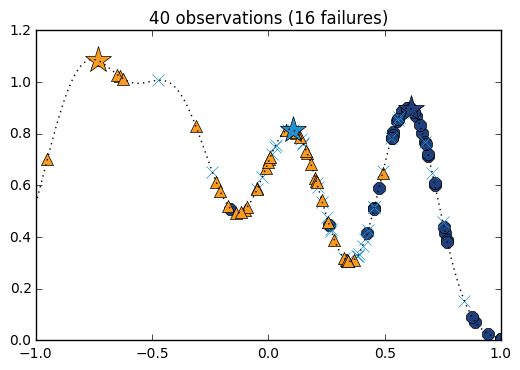

In [21]:
x = [[] for _ in parameters]
yfull = []
y = [[] for _ in parameters]
num_failures = 0
for obs in conn.experiments(experiment.id).observations().fetch().iterate_pages():
    if obs.value is not None:
        for k, (_, xval) in enumerate(sorted(obs.assignments.items())):
            x[k].append(xval)
        yfull.append(obs.value)
        metadata = [o[1] for o in sorted(obs.metadata.items(), key=lambda x: x[0]) if o[0][0] == 'f']
        for k, fval in enumerate(metadata):
            y[k].append(fval)
    else:
        num_failures += 1

markers = ['o', 'x', '^', 's']
for k, (this_x, this_y) in enumerate(zip(x, y)):
    plt.plot(this_x, this_y, markers[k], color=sigopt_colors[k], markersize=9)
for which_optimum in range(num_optima):
    plt.plot(answer.assignments['x1--{0}'.format(which_optimum + 1)], answer.metadata['f{0}_value'.format(which_optimum)], '*', color=sigopt_colors[which_optimum], markersize=20)
plt.plot(xplt, yplt, ':k')
plt.title('{0} observations ({1} failures)'.format(len(yfull), num_failures));

In [22]:
test_function = test_function_2d
distance_function = list_distance_function
experiment_name = 'Simultaneous multisolution test 2D'

num_optima = 4
parameters = list(create_duplicate_parameters(parameters_2d, num_optima))
num_trials = 100

In [23]:
assert I_AM_OKAY_CREATING_EXPERIMENTS
experiment = conn.experiments().create(
    name=experiment_name,
    parameters=parameters,
)

In [24]:
for trial in range(num_trials):
    suggestion = conn.experiments(experiment.id).suggestions().create()
    observation_list = create_success_and_failure_observations(suggestion, parameters, test_function, distance_function)
    for observation in observation_list:
        conn.experiments(experiment.id).observations().create(**observation)
answer = conn.experiments(experiment.id).fetch().progress.best_observation

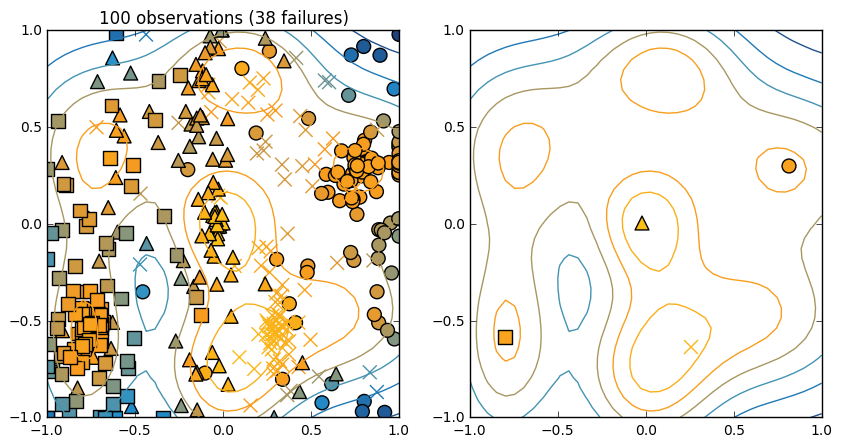

In [25]:
x = [[] for _ in range(len(parameters) / 2)]
yfull = []
y = [[] for _ in range(len(parameters) / 2)]
num_failures = 0
for obs in conn.experiments(experiment.id).observations().fetch().iterate_pages():
    if obs.value is not None:
        edl = identify_individual_dicts(parameters, obs)
        for k, eval_dict in enumerate(edl):
            points = []
            for j, (name, val) in enumerate(eval_dict.items()):
                points.append(val)
            x[k].append(points)
        yfull.append(obs.value)
        metadata = [o[1] for o in sorted(obs.metadata.items(), key=lambda x: x[0]) if o[0][0] == 'f']
        for k, fval in enumerate(metadata):
            y[k].append(fval)
    else:
        num_failures += 1
            
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
markers = ['o', 'x', '^', 's']
for k, (this_x, this_y) in enumerate(zip(x, y)):
    this_x = numpy.array(this_x)
    ax1.scatter(this_x[:, 0], this_x[:, 1], c=this_y, s=100, marker=markers[k], cmap=cmap_sigopt, vmin=numpy.min(Y_2D), vmax=numpy.max(Y_2D))
ax1.contour(X1_2D, X2_2D, Y_2D, cmap=cmap_sigopt, vmin=numpy.min(Y_2D), vmax=numpy.max(Y_2D))
ax1.set_xlim((-1, 1))
ax1.set_ylim((-1, 1))
ax1.set_title('{0} observations ({1} failures)'.format(len(yfull), num_failures))

ax2.contour(X1_2D, X2_2D, Y_2D, cmap=cmap_sigopt, vmin=numpy.min(Y_2D), vmax=numpy.max(Y_2D))
for which_optimum in range(num_optima):
    ax2.scatter(answer.assignments['x1--{0}'.format(which_optimum + 1)], answer.assignments['x2--{0}'.format(which_optimum + 1)], c=answer.metadata['f{0}_value'.format(which_optimum)], s=100, marker=markers[which_optimum], cmap=cmap_sigopt, vmin=numpy.min(Y_2D), vmax=numpy.max(Y_2D))
ax2.set_xlim((-1, 1))
ax2.set_ylim((-1, 1));

In [26]:
test_function = test_function_3d
distance_function = list_distance_function
experiment_name = 'Simultaneous multisolution test 3D'

num_optima = 4
parameters = list(create_duplicate_parameters(parameters_3d, num_optima))
num_trials = 200

In [27]:
assert I_AM_OKAY_CREATING_EXPERIMENTS
experiment = conn.experiments().create(
    name=experiment_name,
    parameters=parameters,
)

In [28]:
for trial in range(num_trials):
    suggestion = conn.experiments(experiment.id).suggestions().create()
    observation_list = create_success_and_failure_observations(suggestion, parameters, test_function, distance_function)
    for observation in observation_list:
        conn.experiments(experiment.id).observations().create(**observation)
answer = conn.experiments(experiment.id).fetch().progress.best_observation

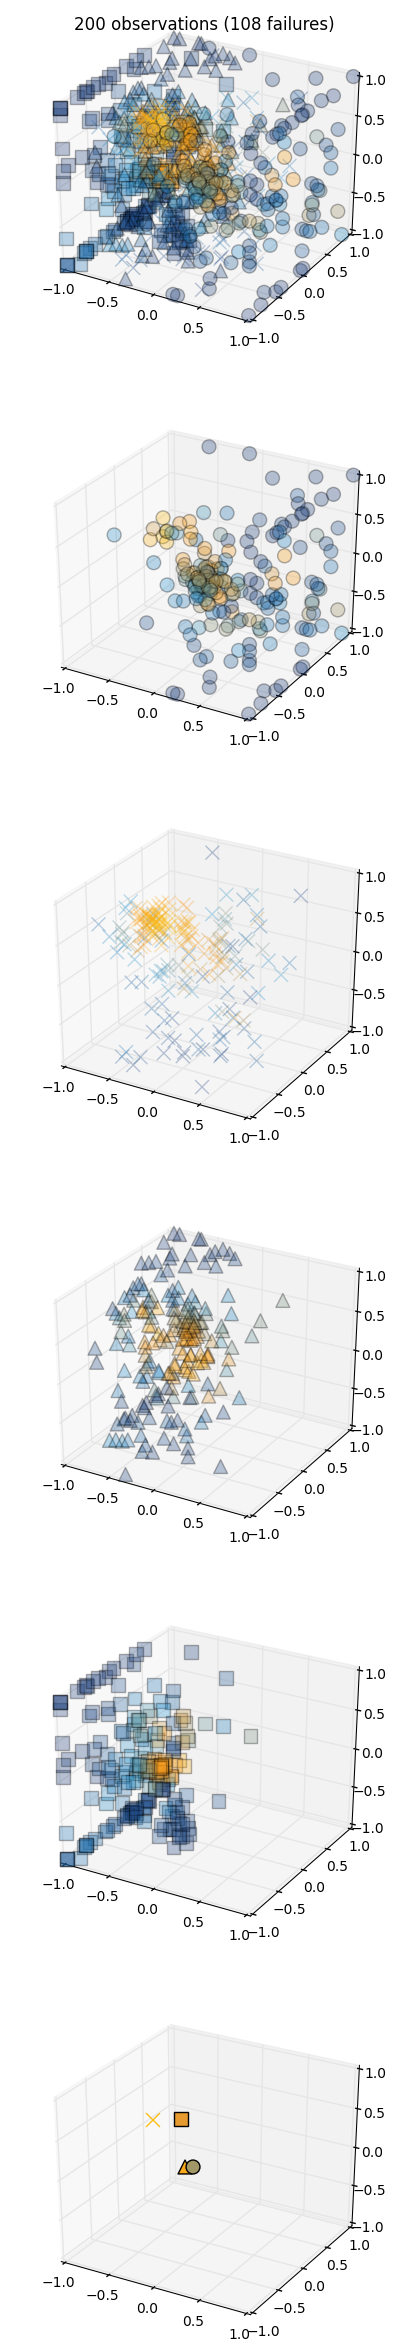

In [29]:
x = [[] for _ in range(len(parameters) / 3)]
yfull = []
y = [[] for _ in range(len(parameters) / 3)]
num_failures = 0
for obs in conn.experiments(experiment.id).observations().fetch().iterate_pages():
    if obs.value is not None:
        edl = identify_individual_dicts(parameters, obs)
        for k, eval_dict in enumerate(edl):
            points = []
            for j, (name, val) in enumerate(eval_dict.items()):
                points.append(val)
            x[k].append(points)
        yfull.append(obs.value)
        metadata = [o[1] for o in sorted(obs.metadata.items(), key=lambda x: x[0]) if o[0][0] == 'f']
        for k, fval in enumerate(metadata):
            y[k].append(fval)
    else:
        num_failures += 1

# This plotting is still restricted to <= 4 
fig, axes = plt.subplots(2 + num_optima, 1, figsize=(5, 5 * (2 + num_optima)), subplot_kw={'projection': '3d'})
markers = ['o', 'x', '^', 's']
for k, (this_x, this_y) in enumerate(zip(x, y)):
    this_x = numpy.array(this_x)
    axes[0].scatter(this_x[:, 0], this_x[:, 1], this_x[:, 2], c=this_y, s=100, marker=markers[k], alpha=.3, cmap=cmap_sigopt, vmin=numpy.min(Y_3D), vmax=numpy.max(Y_3D))
axes[0].set_xlim((-1, 1))
axes[0].set_ylim((-1, 1))
axes[0].set_zlim((-1, 1))
axes[0].set_title('{0} observations ({1} failures)'.format(len(yfull), num_failures))

for which_optimum, (this_x, this_y, ax) in enumerate(zip(x, y, axes[1:-1])):
    this_x = numpy.array(this_x)
    ax.scatter(this_x[:, 0], this_x[:, 1], this_x[:, 2], c=this_y, s=100, marker=markers[which_optimum], alpha=.3, cmap=cmap_sigopt, vmin=numpy.min(Y_3D), vmax=numpy.max(Y_3D))
    ax.set_xlim((-1, 1))
    ax.set_ylim((-1, 1))
    ax.set_zlim((-1, 1))

for which_optimum in range(num_optima):
    axes[-1].scatter(
        answer.assignments['x1--{0}'.format(which_optimum + 1)], answer.assignments['x2--{0}'.format(which_optimum + 1)], answer.assignments['x3--{0}'.format(which_optimum + 1)],
        c=answer.metadata['f{0}_value'.format(which_optimum)], s=100, marker=markers[which_optimum],
        cmap=cmap_sigopt, vmin=numpy.min(Y_3D), vmax=numpy.max(Y_3D)
    )
axes[-1].set_xlim((-1, 1))
axes[-1].set_ylim((-1, 1))
axes[-1].set_zlim((-1, 1));

# Attempt a multicriteria strategy

This is much more complicated because it relies on a new mathematical strategy not currently supported in SigOpt (though we are working to implement it right now).  The strategy in particular involves a multicriteria solution to the problem - in this setting we assume that we already have one solution available and all other solutions are defined as trying to maximize both the function value and the distance from the already present solution.

The implementation provided below is an initial version which sits on top of SigOpt and manages the multicriteria component within this notebook.  Obviously this is not ideal, and we hope to have a multicriteria solver available internally soon.

The greatest difference between this method and other methods is that there are not specific "answers".  What is returned from this problem is all the computed values, and in particular a set of values on the so-called Pareto frontier.  We have blog posts [introducing this concept](http://blog.sigopt.com/post/149041563563/sigopt-in-depth-intro-to-multicriteria) and [discussing an application](http://blog.sigopt.com/post/151388283013/sigopt-in-depth-building-a-better-mousetrap-via).  You will have the opportunity to review values on the Pareto frontier (values for which any improvement in one metric will yield a penalty in the other) and make a judgment as to what is appropriate.

This strategy as implemented here exists in two parts (finding the global optimum, and then conducting a multicriteria analysis) but it could also exist as a supplement to the iterative strategy described above.  This might look like using the iterative strategy to instead find the 2 best optima and then running the multicriteria method.  It could also consist of using the multicriteria method iteratively and augmenting the sense of distance after each new solution is chosen.

Our search of the Pareto frontier is conducted with a weighted-sum scalarization, but there are other methods available as well, some of which might be preferable under various circumstances.  In particular, we consider in those blog posts the use of a constraint-based method; such a strategy could actually be preferable because it could be phrased somewhat flexibly:

* Find the highest value point at least some distance away from the current solution (similarly to what we saw before in the iterative scheme), or
* Find the point furthest away from the current solution which has at least some acceptable quality (which would require the stating of such a threshold).

Additionally, because of the information we have about this problem, it might be possible to create an ideal point and rephrase quality using a norm, although doing so would then introduce some ambiguity in the sense of what the norm is.

In [69]:
def scalarization(weight_on_f_val, f_val, distance):
    return weight_on_f_val * f_val + (1 - weight_on_f_val) * distance

def augment_initial_experiment(conn, experiment_id, distance_function):
    first_answer = conn.experiments(experiment_id).fetch().progress.best_observation
    for obs in conn.experiments(experiment_id).observations().fetch().iterate_pages():
        try:
            distance = distance_function(obs.assignments, first_answer.assignments)
        except AssertionError:  # Added to prevent unexpected behavior, but this is an edge case
            distance = 0
        conn.experiments(experiment_id).observations(obs.id).update(
            metadata={'f_val': obs.value, 'distance': distance}
        )

def add_historical_info(conn, new_experiment_id, old_experiment_id, weight_on_f_val):
    for obs in conn.experiments(old_experiment_id).observations().fetch().iterate_pages():
        metadata = dict(obs.metadata)
        f_val = metadata['f_val']
        distance = metadata['distance']
        metadata['weight_on_f_val'] = weight_on_f_val
        value = scalarization(weight_on_f_val, f_val, distance)
        conn.experiments(new_experiment_id).observations().create(
            assignments=obs.assignments,
            value=value,
            metadata=metadata,
        )

def find_pareto_efficient_func_dist(f_vec, d_vec, *args):
    objpred = numpy.array([f_vec, d_vec])

    good_ind = []
    bad_ind = []
    pareto_efficient_parameters = []
    for j, o in enumerate(objpred.T):
        if numpy.all(numpy.any(o[:, numpy.newaxis] >= objpred, axis=0)):
            good_ind.append(j)
            if args:
                pareto_efficient_parameters.append([a[j] for a in args])
        else:
            bad_ind.append(j)
    pareto_front = objpred[:, good_ind]
    non_pareto_front = objpred[:, bad_ind]
    
    return pareto_front, non_pareto_front, pareto_efficient_parameters

def find_near_pareto_frontier(pareto_frontier, non_pareto_frontier, *args, **kwargs):
    tol = kwargs.get('tol', .05)  # This default is set here arbitrarily
    good_ind = []
    nearly_pareto_efficient_parameters = []
    for j, o in enumerate(non_pareto_frontier.T):
        if numpy.any(numpy.linalg.norm(o[:, numpy.newaxis] - pareto_frontier, axis=0) < tol):
            good_ind.append(j)
            if args:
                nearly_pareto_efficient_parameters.append([a[j] for a in args])
    nearly_pareto_frontier = non_pareto_frontier[:, good_ind]
    
    return nearly_pareto_frontier, nearly_pareto_efficient_parameters

In [48]:
test_function = test_function_1d
distance_function = pairwise_distance_function
experiment_name = 'Multicriteria multisolution test 1D'

parameters = parameters_1d
num_evals_per_weight = 10
num_weights = 6
f_val_weight_vec = numpy.linspace(.9, .1, num_weights)  # This is chosen arbitrarily and could be improved

In [36]:
assert I_AM_OKAY_CREATING_EXPERIMENTS
experiment = conn.experiments().create(
    name='{0}, base'.format(experiment_name),
    parameters=parameters,
)

Here is the initial solve to find the global optimum.  We give it some extra points to make sure the solution is high quality.  These computations will be reused during the multicriteria component so there is little lost in doing so.

After we solve this, we supplement the experiment with metadata to be used during the multicriteria solution.

In [62]:
for trial in range(2 * num_evals_per_weight):
    suggestion = conn.experiments(experiment.id).suggestions().create()
    value = test_function(**suggestion.assignments)
    conn.experiments(experiment.id).observations().create(
        suggestion=suggestion.id,
        value=value,
    )
base_answer = conn.experiments(experiment.id).fetch().progress.best_observation
augment_initial_experiment(conn, experiment.id, distance_function)

Now, a number of different experiments are created, each of which uses the data from all previous experiments after some alteration to account for the different weighting associated with the current experiment.

In [63]:
assert I_AM_OKAY_CREATING_EXPERIMENTS
all_experiments = [experiment]

for exp_num, weight_on_f_val in enumerate(f_val_weight_vec):
    experiment = conn.experiments().create(
        name='{0}, f weight {1:3.3f}'.format(experiment_name, weight_on_f_val),
        parameters=parameters,
    )
    add_historical_info(conn, experiment.id, all_experiments[-1].id, weight_on_f_val)
    
    for _ in range(num_evals_per_weight):
        suggestion = conn.experiments(experiment.id).suggestions().create()
        f_val = test_function(**suggestion.assignments)
        distance = distance_function(suggestion.assignments, base_answer.assignments)
        conn.experiments(experiment.id).observations().create(
            suggestion=suggestion.id,
            value=scalarization(weight_on_f_val, f_val, d_val),
            metadata={'weight_on_f_val': weight_on_f_val, 'f_val': f_val, 'distance': distance},
        )
    
    print 'Trial {0} of {1} completed with {2} observations and f_val weight {3}'.format(exp_num + 1, num_weights, num_evals_per_weight, weight_on_f_val)
    all_experiments.append(experiment)

{u'distance': 1.6536603534558298, u'f_val': 0.06444399174530775}
{u'distance': 0.05423893108910216, u'f_val': 1.0578768594645374}
{u'distance': 0.2623616516680992, u'f_val': 1.0048620754337532}
{u'distance': 0.24279649393900005, u'f_val': 0.530128424481707}
{u'distance': 0.0, u'f_val': 1.0879699079884817}
{u'distance': 0.20089109792399995, u'f_val': 0.9954848180777169}
{u'distance': 0.009286734128000074, u'f_val': 1.0871302474546503}
{u'distance': 1.4450571188549999, u'f_val': 0.7141159698608223}
{u'distance': 0.27529743021099995, u'f_val': 1.0066771866023088}
{u'distance': 0.7190595401559999, u'f_val': 0.6073236649328996}
{u'distance': 1.176795332324, u'f_val': 0.4012617768613204}
{u'distance': 0.46657719711299994, u'f_val': 0.7765983989072909}
{u'distance': 0.006381588524999926, u'f_val': 1.0876529604141734}
{u'distance': 0.10912183797199992, u'f_val': 1.0274336217742528}
{u'distance': 0.074902214947, u'f_val': 1.0290172654488887}
{u'distance': 0.08259787781400008, u'f_val': 1.015727

Note below, in plotting the points that were sampled during the optimization and the Pareto frontier of efficient points (in red) that the objectives we are trying to study here are clearly not convex (as was probably apparent just from looking at the function as shown on the right).  As a result, the weighted sum scalarization method will not be able to effectively resolve the entire Pareto frontier.  The region of points on the Pareto frontier near the x-value -0.5, in particular, are not points that can be well studied using the weighted sum scalarization.

Furthermore, the number of points present in the region near x=1.0 is because a significant portion of the weights are associated with that region.  Recall that the f_val weight vector ranged from .1 to .9 -- if the weight applied to the function value during the scalarization is only .1, then the optimization will strongly prefer points which are far away from the optimum, almost regardless of how bad the actual function value may be.  It is possible to implement some sort of better bounding on that weight value, subject to knowing the max of the function (from the first optimization) and the domain of interest (from the problem definition).  That will be implemented in SigOpt at some point pending further research.

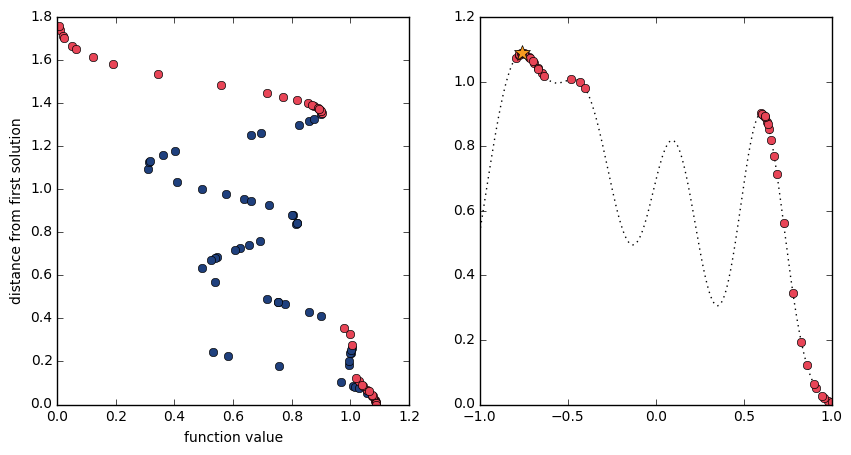

In [85]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

x = []
f_vals = []
d_vals = []
for obs in conn.experiments(all_experiments[-1].id).observations().fetch().iterate_pages():
    x.append(obs.assignments['x1'])
    f_vals.append(obs.metadata['f_val'])
    d_vals.append(obs.metadata['distance'])

pf, npf, efficient_parameters = find_pareto_efficient_func_dist(f_vals, d_vals, x, f_vals)
ax1.plot(npf[0, :], npf[1, :], 'o', color='#1F407D')
ax1.plot(pf[0, :], pf[1, :], 'o', color='#E84557')
ax1.set_xlabel('function value')
ax1.set_ylabel('distance from first solution')

efficient_x, efficient_y = numpy.array(efficient_parameters).T
ax2.plot(xplt, yplt, ':k')
ax2.plot(efficient_x, efficient_y, 'o', color='#E84557')
ax2.plot([base_answer.assignments['x1']], [base_answer.value], '*', color='#F89B20', markersize=12);

In [89]:
test_function = test_function_2d
distance_function = pairwise_distance_function
experiment_name = 'Multicriteria multisolution test 2D'

parameters = parameters_2d
num_evals_per_weight = 20
num_weights = 6
f_val_weight_vec = numpy.linspace(.7, .3, num_weights)

In [87]:
assert I_AM_OKAY_CREATING_EXPERIMENTS
experiment = conn.experiments().create(
    name='{0}, base'.format(experiment_name),
    parameters=parameters,
)

In [90]:
for trial in range(2 * num_evals_per_weight):
    suggestion = conn.experiments(experiment.id).suggestions().create()
    value = test_function(**suggestion.assignments)
    conn.experiments(experiment.id).observations().create(
        suggestion=suggestion.id,
        value=value,
    )
base_answer = conn.experiments(experiment.id).fetch().progress.best_observation
augment_initial_experiment(conn, experiment.id, distance_function)

In [91]:
assert I_AM_OKAY_CREATING_EXPERIMENTS
all_experiments = [experiment]

for exp_num, weight_on_f_val in enumerate(f_val_weight_vec):
    experiment = conn.experiments().create(
        name='{0}, f weight {1:3.3f}'.format(experiment_name, weight_on_f_val),
        parameters=parameters,
    )
    add_historical_info(conn, experiment.id, all_experiments[-1].id, weight_on_f_val)
    
    for _ in range(num_evals_per_weight):
        suggestion = conn.experiments(experiment.id).suggestions().create()
        f_val = test_function(**suggestion.assignments)
        distance = distance_function(suggestion.assignments, base_answer.assignments)
        conn.experiments(experiment.id).observations().create(
            suggestion=suggestion.id,
            value=scalarization(weight_on_f_val, f_val, d_val),
            metadata={'weight_on_f_val': weight_on_f_val, 'f_val': f_val, 'distance': distance},
        )
    
    print 'Trial {0} of {1} completed with {2} observations and f_val weight {3}'.format(exp_num + 1, num_weights, num_evals_per_weight, weight_on_f_val)
    all_experiments.append(experiment)

Trial 1 of 6 completed with 20 observations and f_val weight 0.7
Trial 2 of 6 completed with 20 observations and f_val weight 0.633333333333
Trial 3 of 6 completed with 20 observations and f_val weight 0.566666666667
Trial 4 of 6 completed with 20 observations and f_val weight 0.5
Trial 5 of 6 completed with 20 observations and f_val weight 0.433333333333
Trial 6 of 6 completed with 20 observations and f_val weight 0.366666666667
Trial 7 of 6 completed with 20 observations and f_val weight 0.3


Again we have plots of the sampled points and Pareto frontier on the left, and a visualization of the Pareto frontier on the right.  Given that, many of the points not on the Pareto frontier, but close, could still be useful.  The goal of the multicriteria solution strategy is to provide a swath of possible parameters, as many as possible of which have good results, and then enable the user to make an informed decision.

For example, there is a cluster of points with function value near 0.5 and distance near 0.8 which likely represent points at some of the local optima in the top half of the plot on the right.  While these do represent points on the frontier, they are close enough for consideration.  We show the nearly efficient points (as denoted in yellow on the graph on the left) with triangles in the contour map.  Furthermore, in the presence of uncertainty (as is often the case in practice) there may be some doubt as to the accuracy of the found Pareto frontier and thus using points near it should be nearly efficient.

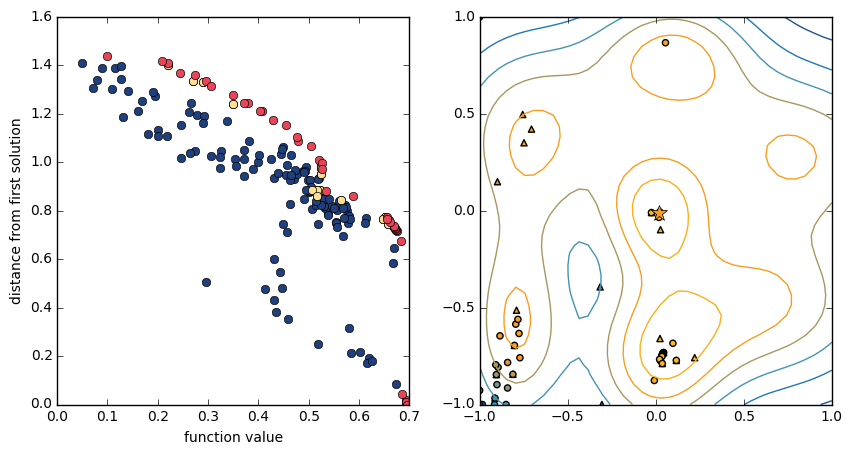

In [133]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

x1 = []
x2 = []
f_vals = []
d_vals = []
for obs in conn.experiments(all_experiments[-1].id).observations().fetch().iterate_pages():
    x1.append(obs.assignments['x1'])
    x2.append(obs.assignments['x2'])
    f_vals.append(obs.metadata['f_val'])
    d_vals.append(obs.metadata['distance'])

pf, npf, efficient_parameters = find_pareto_efficient_func_dist(f_vals, d_vals, x1, x2, f_vals)
nearly_pf, nearly_ep = find_near_pareto_frontier(pf, npf, x1, x2, f_vals, tol=.03)
ax1.plot(npf[0, :], npf[1, :], 'o', color='#1F407D')
ax1.plot(nearly_pf[0, :], nearly_pf[1, :], 'o', color='#FEDF93')
ax1.plot(pf[0, :], pf[1, :], 'o', color='#E84557')
ax1.set_xlabel('function value')
ax1.set_ylabel('distance from first solution')

efficient_x1, efficient_x2, efficient_z = numpy.array(efficient_parameters).T
ne_x1, ne_x2, ne_z = numpy.array(nearly_ep).T
ax2.contour(X1_2D, X2_2D, Y_2D, cmap=cmap_sigopt, vmin=numpy.min(Y_2D), vmax=numpy.max(Y_2D))
ax2.plot([base_answer.assignments['x1']], [base_answer.assignments['x2']], '*', color='#F89B20', markersize=12);
ax2.scatter(ne_x1, ne_x2, c=ne_z, marker='^', cmap=cmap_sigopt, vmin=numpy.min(Y_2D), vmax=numpy.max(Y_2D))
ax2.scatter(efficient_x1, efficient_x2, c=efficient_z, marker='o', cmap=cmap_sigopt, vmin=numpy.min(Y_2D), vmax=numpy.max(Y_2D))
ax2.set_xlim((-1, 1))
ax2.set_ylim((-1, 1));

In [98]:
test_function = test_function_3d
distance_function = pairwise_distance_function
experiment_name = 'Multicriteria multisolution test 3D'

parameters = parameters_3d
num_evals_per_weight = 30
num_weights = 6
f_val_weight_vec = numpy.linspace(.7, .3, num_weights)

In [99]:
assert I_AM_OKAY_CREATING_EXPERIMENTS
experiment = conn.experiments().create(
    name='{0}, base'.format(experiment_name),
    parameters=parameters,
)

In [100]:
suggestion = conn.experiments(experiment.id).suggestions().delete()
for trial in range(2 * num_evals_per_weight):
    suggestion = conn.experiments(experiment.id).suggestions().create()
    value = test_function(**suggestion.assignments)
    conn.experiments(experiment.id).observations().create(
        suggestion=suggestion.id,
        value=value,
    )
base_answer = conn.experiments(experiment.id).fetch().progress.best_observation
augment_initial_experiment(conn, experiment.id, distance_function)

In [101]:
assert I_AM_OKAY_CREATING_EXPERIMENTS
all_experiments = [experiment]

for exp_num, weight_on_f_val in enumerate(f_val_weight_vec):
    experiment = conn.experiments().create(
        name='{0}, f weight {1:3.3f}'.format(experiment_name, weight_on_f_val),
        parameters=parameters,
    )
    add_historical_info(conn, experiment.id, all_experiments[-1].id, weight_on_f_val)
    
    for _ in range(num_evals_per_weight):
        suggestion = conn.experiments(experiment.id).suggestions().create()
        f_val = test_function(**suggestion.assignments)
        distance = distance_function(suggestion.assignments, base_answer.assignments)
        conn.experiments(experiment.id).observations().create(
            suggestion=suggestion.id,
            value=scalarization(weight_on_f_val, f_val, d_val),
            metadata={'weight_on_f_val': weight_on_f_val, 'f_val': f_val, 'distance': distance},
        )
    
    print 'Trial {0} of {1} completed with {2} observations and f_val weight {3}'.format(exp_num + 1, num_weights, num_evals_per_weight, weight_on_f_val)
    all_experiments.append(experiment)

Trial 1 of 6 completed with 30 observations and f_val weight 0.7
Trial 2 of 6 completed with 30 observations and f_val weight 0.62
Trial 3 of 6 completed with 30 observations and f_val weight 0.54
Trial 4 of 6 completed with 30 observations and f_val weight 0.46
Trial 5 of 6 completed with 30 observations and f_val weight 0.38
Trial 6 of 6 completed with 30 observations and f_val weight 0.3


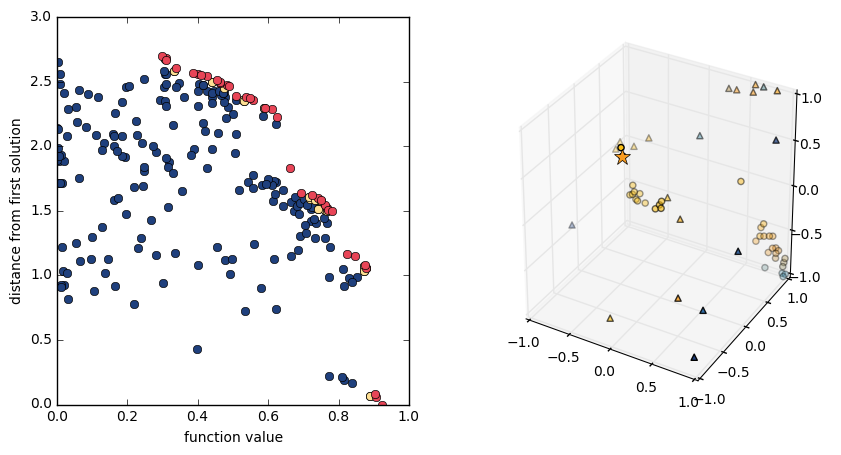

In [139]:
fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122, projection='3d')

x1 = []
x2 = []
x3 = []
f_vals = []
d_vals = []
for obs in conn.experiments(all_experiments[-1].id).observations().fetch().iterate_pages():
    x1.append(obs.assignments['x1'])
    x2.append(obs.assignments['x2'])
    x3.append(obs.assignments['x3'])
    f_vals.append(obs.metadata['f_val'])
    d_vals.append(obs.metadata['distance'])

pf, npf, efficient_parameters = find_pareto_efficient_func_dist(f_vals, d_vals, x1, x2, x3, f_vals)
nearly_pf, nearly_ep = find_near_pareto_frontier(pf, npf, x1, x2, x3, f_vals, tol=.03)
ax1.plot(npf[0, :], npf[1, :], 'o', color='#1F407D')
ax1.plot(nearly_pf[0, :], nearly_pf[1, :], 'o', color='#FEDF93')
ax1.plot(pf[0, :], pf[1, :], 'o', color='#E84557')
ax1.set_xlabel('function value')
ax1.set_ylabel('distance from first solution')

efficient_x1, efficient_x2, efficient_x3, efficient_z = numpy.array(efficient_parameters).T
ne_x1, ne_x2, ne_x3, ne_z = numpy.array(nearly_ep).T
ax2.plot([base_answer.assignments['x1']], [base_answer.assignments['x2']], [base_answer.assignments['x3']], '*', color='#F89B20', markersize=12);
ax2.scatter(ne_x1, ne_x2, ne_x2, c=ne_z, marker='^', cmap=cmap_sigopt, vmin=numpy.min(Y_2D), vmax=numpy.max(Y_2D))
ax2.scatter(efficient_x1, efficient_x2, efficient_x3, c=efficient_z, marker='o', cmap=cmap_sigopt, vmin=numpy.min(Y_2D), vmax=numpy.max(Y_2D))
ax2.set_xlim((-1, 1))
ax2.set_ylim((-1, 1))
ax2.set_zlim((-1, 1));